### Inport necessary packages

In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt

In [3]:
import random
import numpy as np

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:
import os
import cv2

In [6]:
seed = 21520064

In [7]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load Folio Leaf Dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
root_dir = '/content/drive/MyDrive/UIT/Năm 2/CS115/Folio Leaf Dataset' # Example: '/content/drive/MyDrive/CS115/Folio Leaf Dataset'

In [10]:
list_folders = os.listdir(root_dir)
list_folders

['bitter orange',
 'chrysanthemum',
 'caricature plant',
 'chocolate tree',
 'chinese guava',
 'barbados cherry',
 'betel',
 'beaumier du perou',
 'coeur demoiselle',
 'ashanti blood',
 'guava',
 'fruitcitere',
 'coffee',
 'hibiscus',
 'geranium',
 'croton',
 'duranta gold',
 'jackfruit',
 'eggplant',
 'ficus',
 'pimento',
 'papaya',
 'ketembilla',
 'sweet potato',
 'sweet olive',
 'mulberry leaf',
 'rose',
 'pomme jacquot',
 'lychee',
 'star apple',
 'thevetia',
 'vieux garcon']

In [11]:
def resize(image):
    return cv2.resize(image, (232, 412))

### Process the raw data

In [12]:
# Create dataset (X, y)
X, y = [], []
for folder in list_folders:
  list_image_paths = os.listdir(root_dir + '/' + folder)
  for image_path in list_image_paths:
    img_matrix = resize(cv2.imread(root_dir + '/' + folder + '/' + image_path, 0))
    X.append([img_matrix])
    y.append(folder)

In [13]:
# Task: Normalize the value of each pixel by dividing them to 255
X = np.array(X) / 255

In [14]:
# Task: Perform 'label encoding' on y
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
y = le.fit_transform(y)

### Create the train/test set

In [16]:
# Task: Split dataset into training and testing set (7:3, random_seed = Your Student ID)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21520064)

In [17]:
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

In [18]:
# Task: Convert the data type of X_train, X_test, y_train, y_test to 'Tensor'
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [19]:
# Task: Create train_dataset, test_dataset
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [20]:
# Task: Create train_loader (batch_size = 64), test_loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset)

### Implement Classifiers

In [21]:
# Task: Implement "Logistic Regression" model with PyTorch

class LogisticRegression(nn.Module):
    # input_dim -> the number of independent variables (attributes)
    # output_dim -> the number of (unique) classes for classification (e.g., dog-cat -> 2; car-bicycle-plane -> 3)
    def __init__(self, input_dim, output_dim):  
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        logits = self.linear(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [22]:
import torch.optim as optim

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
# Task: Design the 'train_model' function for training models
# Loss Function: Cross Entropy Loss
# Optimizer: Adam -> optim.Adam(model.parameters(), lr=...)

def train_model(data_loader, model, init_lr, maxEpoch):
    # Loss Function
    criterion = nn.CrossEntropyLoss()

    # Optimization Algorithm.
    # We can use other optimizers such as ADAM, RMSprop, etc.
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    
    loss_each_epoch = []  # For tracking the trend of loss value
    
    # Switch model to the training mode
    model.train()

    for epoch in range(maxEpoch):
        sum_loss = 0.0
        for (imgs, labels) in data_loader:
            # Load data to GPU/CPU
            imgs, labels = imgs.to(device), labels.to(device)

            # Change to the correct tensor shape
            # Our data currently is in the format (batch_size, color_channel, w, h) (64, 1, 28, 28)
            # We need to change our data to (batch_size, color_channel * w * h) (64, 1 * 28 * 28)
            imgs = imgs.reshape(imgs.shape[0], -1)

            # forward pass
            logits, _ = model(imgs)  # Feed the training data into the model
            loss = criterion(logits, labels)  # Calculate the loss value

            # backward pass
            optimizer.zero_grad()  # Empty the optimizer
            loss.backward()  # Compute the gradient dJ/dw's

            optimizer.step()  # Update the model's parameters

            sum_loss += loss.item()
        loss_each_epoch.append(sum_loss/len(data_loader.dataset))
        print(f'Epoch {epoch + 1}/{maxEpoch}, Loss: {loss_each_epoch[-1]:.2f}')
    return loss_each_epoch

In [25]:
# Task: Design the 'model_evaluation' function for evaluating the trained models
def model_evaluation(data_loader, model):
    nCorrects = 0
    model.eval()  # put our model on the evaluation mode

    with torch.no_grad():
        for (imgs, labels) in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs.reshape(imgs.shape[0], -1)

            # forward
            _, probs = model(imgs)
            _, y_pred = probs.max(1)
            nCorrects += (y_pred == labels).sum()
    print(f'We got {nCorrects.item()}/{len(data_loader.dataset)} correct. Accuracy = {nCorrects.item()/len(data_loader.dataset) * 100:.2f}%')

In [26]:
# Train Logistic Regression model
# Input dim = 412 * 232
# Output dim = 32
# Initial Learning Rate: 0.001
# Max Epoch = 600
clf_LR = LogisticRegression(input_dim=412 * 232, output_dim=32).to(device)
loss_each_epoch_LR = train_model(data_loader=train_loader, model=clf_LR, init_lr=0.001, maxEpoch=600)

Epoch 1/600, Loss: 1.94
Epoch 2/600, Loss: 2.41
Epoch 3/600, Loss: 3.54
Epoch 4/600, Loss: 4.47
Epoch 5/600, Loss: 3.79
Epoch 6/600, Loss: 2.28
Epoch 7/600, Loss: 1.21
Epoch 8/600, Loss: 0.62
Epoch 9/600, Loss: 0.45
Epoch 10/600, Loss: 0.21
Epoch 11/600, Loss: 0.18
Epoch 12/600, Loss: 0.10
Epoch 13/600, Loss: 0.07
Epoch 14/600, Loss: 0.07
Epoch 15/600, Loss: 0.05
Epoch 16/600, Loss: 0.04
Epoch 17/600, Loss: 0.05
Epoch 18/600, Loss: 0.04
Epoch 19/600, Loss: 0.03
Epoch 20/600, Loss: 0.02
Epoch 21/600, Loss: 0.02
Epoch 22/600, Loss: 0.02
Epoch 23/600, Loss: 0.03
Epoch 24/600, Loss: 0.04
Epoch 25/600, Loss: 0.03
Epoch 26/600, Loss: 0.02
Epoch 27/600, Loss: 0.02
Epoch 28/600, Loss: 0.03
Epoch 29/600, Loss: 0.02
Epoch 30/600, Loss: 0.04
Epoch 31/600, Loss: 0.02
Epoch 32/600, Loss: 0.02
Epoch 33/600, Loss: 0.02
Epoch 34/600, Loss: 0.02
Epoch 35/600, Loss: 0.02
Epoch 36/600, Loss: 0.03
Epoch 37/600, Loss: 0.02
Epoch 38/600, Loss: 0.03
Epoch 39/600, Loss: 0.04
Epoch 40/600, Loss: 0.02
Epoch 41/

Text(0.5, 1.0, 'LogisticRegression Optimize Adam')

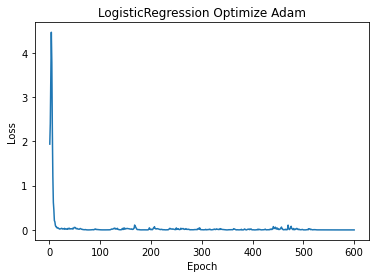

In [27]:
plt.plot(range(1, len(loss_each_epoch_LR) + 1), loss_each_epoch_LR)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LogisticRegression Optimize Adam')

In [28]:
print('Logistic Regression (Train Accuracy)')
model_evaluation(data_loader=train_loader, model=clf_LR)

Logistic Regression (Train Accuracy)
We got 445/445 correct. Accuracy = 100.00%


In [29]:
print('Logistic Regression (Test Accuracy)')
model_evaluation(data_loader=test_loader, model=clf_LR)

Logistic Regression (Test Accuracy)
We got 147/192 correct. Accuracy = 76.56%


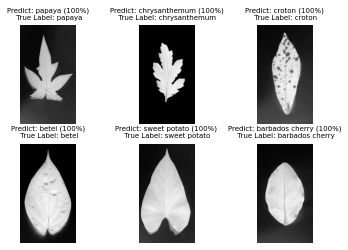

In [30]:
ROW_IMG, N_ROWS = 3, 2

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset[index][0].squeeze(), cmap='gray_r')
    
    with torch.no_grad():
        clf_LR.eval()
        X = test_dataset[index][0].reshape(test_dataset[index][0].shape[0], -1).to(device)
        _, probs = clf_LR(X)
    title = f'Predict: {le.inverse_transform([torch.argmax(probs).item()])[0]} ({torch.max(probs * 100):.0f}%)\n True Label: {le.inverse_transform([test_dataset[index][-1]])[0]}'
    
    plt.title(title, fontsize=7)
plt.show()

In [31]:
# Task: Build a MLP model with 6 layers (input layer, ouput layer and 4 hidden layers)
# The activation of each node in 'input' layer and 'hidden' layers is ReLU
# Information about each layer:
# + Input layer: (input_dim, 2048)
# + Hidden layer 1: (2048, 1024)
# + Hidden layer 2: (1024, 1024)
# + Hidden layer 3: (1024, 512)
# + Hidden layer 4: (512, 512)
# + Output layer: (512, output_dim)
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.classifier = nn.Sequential(
        nn.Linear(input_dim, 2048),
        nn.ReLU(),
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, output_dim)
    )
  def forward(self, x):
    logits = self.classifier(x)
    probs = F.softmax(logits, dim=1)
    return logits, probs

In [32]:
clf_MLP = MLP(input_dim=412 * 232, output_dim=32).to(device)
clf_MLP

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=95584, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=32, bias=True)
  )
)

In [33]:
# Train MLP model
# Input dim = 412 * 233
# Output dim = 32
# Initial Learning Rate: 0.001
# Max Epoch = 600
loss_each_epoch_MLP = train_model(train_loader, clf_MLP, 0.001, 600)

Epoch 1/600, Loss: 0.08
Epoch 2/600, Loss: 0.06
Epoch 3/600, Loss: 0.06
Epoch 4/600, Loss: 0.05
Epoch 5/600, Loss: 0.05
Epoch 6/600, Loss: 0.05
Epoch 7/600, Loss: 0.05
Epoch 8/600, Loss: 0.05
Epoch 9/600, Loss: 0.05
Epoch 10/600, Loss: 0.05
Epoch 11/600, Loss: 0.05
Epoch 12/600, Loss: 0.05
Epoch 13/600, Loss: 0.05
Epoch 14/600, Loss: 0.04
Epoch 15/600, Loss: 0.04
Epoch 16/600, Loss: 0.04
Epoch 17/600, Loss: 0.05
Epoch 18/600, Loss: 0.04
Epoch 19/600, Loss: 0.04
Epoch 20/600, Loss: 0.04
Epoch 21/600, Loss: 0.04
Epoch 22/600, Loss: 0.04
Epoch 23/600, Loss: 0.04
Epoch 24/600, Loss: 0.04
Epoch 25/600, Loss: 0.04
Epoch 26/600, Loss: 0.04
Epoch 27/600, Loss: 0.04
Epoch 28/600, Loss: 0.04
Epoch 29/600, Loss: 0.04
Epoch 30/600, Loss: 0.04
Epoch 31/600, Loss: 0.03
Epoch 32/600, Loss: 0.03
Epoch 33/600, Loss: 0.03
Epoch 34/600, Loss: 0.03
Epoch 35/600, Loss: 0.03
Epoch 36/600, Loss: 0.03
Epoch 37/600, Loss: 0.03
Epoch 38/600, Loss: 0.03
Epoch 39/600, Loss: 0.03
Epoch 40/600, Loss: 0.03
Epoch 41/

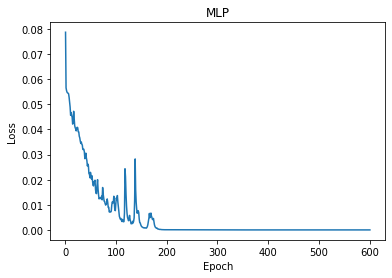

In [34]:
plt.plot(range(1, len(loss_each_epoch_MLP) + 1), loss_each_epoch_MLP)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP')
plt.show()

In [35]:
print('Multi Layer Perceptron (Train Accuracy)')
model_evaluation(train_loader, clf_MLP)

Multi Layer Perceptron (Train Accuracy)
We got 445/445 correct. Accuracy = 100.00%


In [36]:
print('Multi Layer Perceptron (Test Accuracy)')
model_evaluation(test_loader, clf_MLP)

Multi Layer Perceptron (Test Accuracy)
We got 140/192 correct. Accuracy = 72.92%


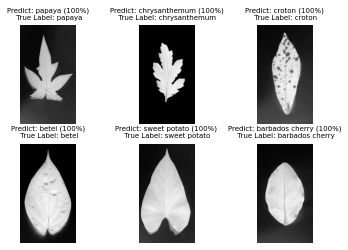

In [37]:
ROW_IMG, N_ROWS = 3, 2

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset[index][0].squeeze(), cmap='gray_r')
    
    with torch.no_grad():
        clf_MLP.eval()
        X = test_dataset[index][0].reshape(test_dataset[index][0].shape[0], -1).to(device)
        _, probs = clf_MLP(X)
    title = f'Predict: {le.inverse_transform([torch.argmax(probs).item()])[0]} ({torch.max(probs * 100):.0f}%)\n True Label: {le.inverse_transform([test_dataset[index][-1]])[0]}'
    
    plt.title(title, fontsize=7)
plt.show()